# Combined SNP and covariate absolute risk model

In this example, we demonstrate the use of iCARE to build and apply models of absolute risk of breast cancer containing both classical risk factors and SNPs. Here, we assume that we have a reference dataset to represent the distribution of the classical risk factors in the underlying population. However, we do not have a reference dataset for the SNPs. So, we make use of iCARE's special SNP option to simulate the reference dataset to represent the distribution of SNPs in the underlying population. If you have a reference dataset for the SNPs as well, you can use the covariate-only option instead because it makes fewer assumptions about the underlying population risk factor distribution.

In [1]:
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns

import icare


# Set the plot background to white
sns.set(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "white"})
seed = 1234

To specify a covariate model in iCARE, we need to provide: 1) a text file containing the covariate model formula description using the [Patsy formula language](https://patsy.readthedocs.io/en/latest/formulas.html) (`model_covariate_formula_path`), 2) the breast cancer log odds ratios associated with each risk factor in the covariate model (`model_log_relative_risk_path`), 3) a reference dataset describing the distribution of the classical risk factors in the underlying population (`model_reference_dataset_path`), 4) a set of profiles, specifying the classical risk factors of individuals for whom, the absolute risk is to be estimated (`apply_covariate_profile_path`), 5) the marginal age-specific incidence rates of breast cancer (`model_disease_incidence_rates_path`), and 6) optionally, the age-specific incidence rates of competing risks (`model_competing_incidence_rates_path`). We include them in this example.

To specify a SNP model using the special option, we must additionally input files containing: 1) the SNP information (`model_snp_info_path`), that has three columns named `snp_name`, `snp_odds_ratio`, and `snp_freq` corresponding to the SNP name, their odds ratios in association with breast cancer risk, and their minor allele frequencies, respectively, and 2) a set of profiles, specifying the SNPs of individuals (same as those specified in the covariate profile) for whom, the absolute risk is to be estimated (`apply_snp_profile_path`).

The covariate model described in the file specified below is based on a logistic regression model adjusted for cohort and fine categories of age in the Breast and Prostate Cancer Cohort Consortium ([Campa et al. 2011](https://pubmed.ncbi.nlm.nih.gov/21791674/), [Joshi et al. 2014](https://pubmed.ncbi.nlm.nih.gov/25255808/), and [Maas et al. 2016](https://pubmed.ncbi.nlm.nih.gov/27228256/)). The reference dataset was created by simulation from [the National Health Interview Survey (NHIS)](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NHIS/2010/srvydesc.pdf) and [the National Health and Nutrition Examination Survey (NHANES)](https://wwwn.cdc.gov/nchs/nhanes/default.aspx), which are representative of the US population. `breast_cancer_72_snps_info.csv` contains published information on the odds-ratios and allele frequencies of 72 SNPs identified, among a larger set of markers, to be associated with breast cancer risk by [a recent genome-wide association study](https://www.nature.com/articles/nature24284) (Michailidou et al., 2017). `age_specific_breast_cancer_incidence_rates.csv` contains age-specific incidence rates of breast cancer from [Surveillance, Epidemiology and End Results (SEER) Program](https://seer.cancer.gov/), and `age_specific_all_cause_mortality_rates.csv` has age-specific incidence rates of all-cause mortality from [the CDC WONDER database](https://wonder.cdc.gov/). We indicate `model_family_history_variable_name = "family_history"` to allow the software to properly attenuate the log odds ratio for family history to account for the addition of the 72 SNPs.

In [2]:
data_dir = pathlib.Path("data")
data_dir.mkdir(exist_ok=True)

In [3]:
# Data files URLs
model_covariate_formula_url = "https://raw.githubusercontent.com/jeyabbalas/py-icare/master/data/breast_cancer_covariate_model_formula.txt"
model_log_relative_risk_url = "https://raw.githubusercontent.com/jeyabbalas/py-icare/master/data/breast_cancer_model_log_odds_ratios.json"
model_reference_dataset_url = "https://raw.githubusercontent.com/jeyabbalas/py-icare/master/data/reference_covariate_data.csv"
apply_covariate_profile_url = "https://raw.githubusercontent.com/jeyabbalas/py-icare/master/data/query_covariate_profile.csv"
model_snp_info_url = "https://raw.githubusercontent.com/jeyabbalas/py-icare/master/data/breast_cancer_72_snps_info.csv"
apply_snp_profile_url = "https://raw.githubusercontent.com/jeyabbalas/py-icare/master/data/query_snp_profile.csv"
model_disease_incidence_rates_url = "https://raw.githubusercontent.com/jeyabbalas/py-icare/master/data/age_specific_breast_cancer_incidence_rates.csv"
model_competing_incidence_rates_url = "https://raw.githubusercontent.com/jeyabbalas/py-icare/master/data/age_specific_all_cause_mortality_rates.csv"

In [4]:
# Data will be downloaded here
model_covariate_formula_path = data_dir / "breast_cancer_covariate_model_formula.txt"
model_log_relative_risk_path = data_dir / "breast_cancer_model_log_odds_ratios.json"
model_reference_dataset_path = data_dir / "reference_covariate_data.csv"
apply_covariate_profile_path = data_dir / "query_covariate_profile.csv"
model_snp_info_path = data_dir / "breast_cancer_72_snps_info.csv"
apply_snp_profile_path = data_dir / "query_snp_profile.csv"
model_disease_incidence_rates_path = data_dir / "age_specific_breast_cancer_incidence_rates.csv"
model_competing_incidence_rates_path = data_dir / "age_specific_all_cause_mortality_rates.csv"

In [5]:
# Download the data
for url, path in zip(
    [
        model_covariate_formula_url,
        model_log_relative_risk_url,
        model_reference_dataset_url,
        apply_covariate_profile_url,
        model_snp_info_url,
        apply_snp_profile_url,
        model_disease_incidence_rates_url,
        model_competing_incidence_rates_url,
    ],
    [
        model_covariate_formula_path,
        model_log_relative_risk_path,
        model_reference_dataset_path,
        apply_covariate_profile_path,
        model_snp_info_path,
        apply_snp_profile_path,
        model_disease_incidence_rates_path,
        model_competing_incidence_rates_path,
    ],
):
    response = requests.get(url)
    response.raise_for_status()
    with open(path, "wb") as f:
        f.write(response.content)

In [6]:
apply_age_start = 50
apply_age_interval_length = 30
model_covariate_formula_path = data_dir / "breast_cancer_covariate_model_formula.txt"
model_log_relative_risk_path = data_dir / "breast_cancer_model_log_odds_ratios.json"
model_reference_dataset_path = data_dir / "reference_covariate_data.csv"
apply_covariate_profile_path = data_dir / "query_covariate_profile.csv"
model_snp_info_path = data_dir / "breast_cancer_72_snps_info.csv"
apply_snp_profile_path = data_dir / "query_snp_profile.csv"
model_family_history_variable_name = "family_history"
model_disease_incidence_rates_path = data_dir / "age_specific_breast_cancer_incidence_rates.csv"
model_competing_incidence_rates_path = data_dir / "age_specific_all_cause_mortality_rates.csv"

In [7]:
results = icare.compute_absolute_risk(
    apply_age_start=apply_age_start,
    apply_age_interval_length=apply_age_interval_length,
    model_covariate_formula_path=model_covariate_formula_path,
    model_log_relative_risk_path=model_log_relative_risk_path,
    model_reference_dataset_path=model_reference_dataset_path,
    apply_covariate_profile_path=apply_covariate_profile_path,
    model_snp_info_path=model_snp_info_path,
    apply_snp_profile_path=apply_snp_profile_path,
    model_family_history_variable_name=model_family_history_variable_name,
    model_disease_incidence_rates_path=model_disease_incidence_rates_path,
    model_competing_incidence_rates_path=model_competing_incidence_rates_path,
    return_reference_risks=True,
    seed=seed # set the random seed for reproducibility
)

The method returns a dictionary containing the following keys:

In [8]:
results.keys()

dict_keys(['model', 'profile', 'reference_risks', 'method'])

The `method` key contains the name of the iCARE method used:

In [9]:
print(f"iCARE method used: {results['method']}")

iCARE method used: iCARE - absolute risk


The `model` key contains the absolute risk model parameters, i.e., the log odds-ratios for each classical risk factor and SNP in association with breast cancer risk:

In [10]:
model = pd.Series(results["model"])
model

C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.11-11.5]    0.044431
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.11.5-12]   -0.035407
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.12-13]     -0.086565
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.13-14]     -0.109902
C(age_at_menarche, levels=['<=11', '11-11.5', '11.5-12', '12-13', '13-14', '14-15', '>=15'])[T.14-15]     -0.085482
                                                                                                             ...   
rs2284378                                                                                                  0.000000
rs2823093                                                                                                 -0.061875
rs17879961                                                              

The `profile` key contains the classical risk factors, genetic risk factors, and the estimated absolute risk for each queried profile:

In [11]:
profiles = pd.read_json(results["profile"], orient="records")
profiles.set_index("id", inplace=True)
profiles

,age_interval_start,age_interval_end,risk_estimates,family_history,age_at_menarche,parity,age_at_first_child_birth,age_at_menopause,height,bmi,...,rs527616,rs1436904,rs6507583,rs4808801,rs3760982,rs2284378,rs2823093,rs17879961,rs132390,rs6001930
id,,,,,,,,,,,,,,,,,,,,,
Q-01,50,80,0.102086,0,13-14,0,19-22,40-45,1.63-1.65,>=34.6,...,0,0,0,1,0,1,1,0,0,0
Q-02,50,80,0.090077,0,>=15,0,19-22,<=40,1.63-1.65,24.2-25.3,...,0,0,0,1,1,1,0,0,0,0
Q-03,50,80,0.168964,0,<=11,0,<=19,51-52,<=1.55,>=34.6,...,1,1,0,1,1,0,0,0,0,0


The `reference_risks` key contains the absolute risks of the reference population. The population estimated risks are stored in the `reference_risks` key. It contains a list of dictionaries, one per unique combination of age intervals. Since, we calculated the risks for the interval from age 50 to 80 for all individuals, there is only one dictionary in the list:

In [12]:
reference_risks = results["reference_risks"]

We can calculate the summary statistics of the reference population risks as shown below. We can see that the population mean risk is `0.096`.

In [13]:
pd.DataFrame(reference_risks[0]["population_risks"]).describe()

,0
count,14137.000000
mean,0.096224
std,0.032180
min,0.033011
25%,0.073251
50%,0.090267
75%,0.112703
max,0.310007


We can plot the absolute risks of the reference population and the queried profiles:

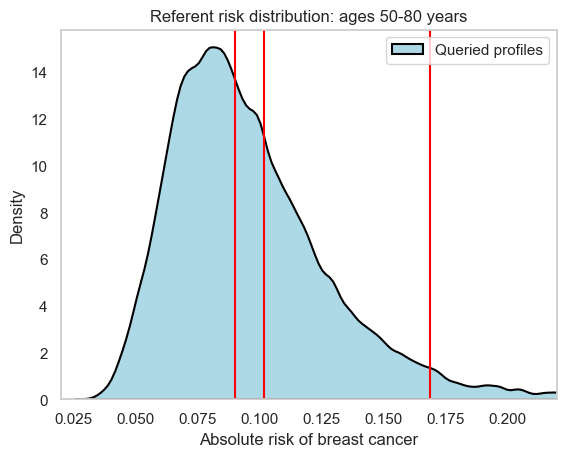

In [14]:
# Plot the density plot
sns.kdeplot(reference_risks[0]["population_risks"], bw_adjust=0.5, color="black", fill=True, alpha=0.3, linewidth=1.5, facecolor="lightblue")
plt.xlim(0.02, 0.22)
plt.xlabel("Absolute risk of breast cancer")
plt.title("Referent risk distribution: ages 50-80 years")

# Add a vertical red line, one for each queried profile
for risk_value in profiles["risk_estimates"]:
    plt.axvline(risk_value, color="red")

plt.legend(["Queried profiles"], loc="upper right")

plt.show()